# GANs For Art

## Importing the modules

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
%matplotlib inline

## Preparing the data

In [2]:
batch_size = 128
image_size = (64,64)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
transform_ds = transforms.Compose([transforms.Resize(image_size),
#                                    transforms.RandomCrop(32, padding=2),
#                                    transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Normalize(*stats)
                                   ])

train_ds = torchvision.datasets.ImageFolder(root="Z:\ArtGenerator\Data",
                                     transform=transform_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
print(len(train_ds))

12342


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])


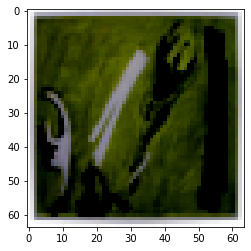

In [4]:
images,_ = train_ds[30]
print(images.size())
plt.imshow(images.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


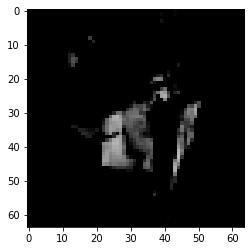

In [5]:
images,_ = train_ds[2]
plt.imshow(images.permute(1,2,0))

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [7]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

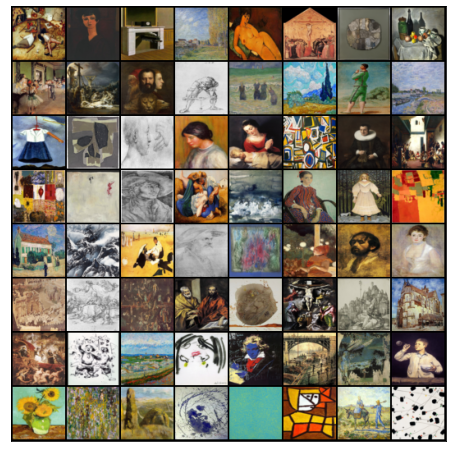

In [8]:
show_batch(train_dl)

In [9]:
torch.cuda.is_available()

True

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [14]:
discriminator = to_device(discriminator, device)

In [15]:
latent_size = 150

In [16]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

## Defining the model

torch.Size([128, 3, 64, 64])


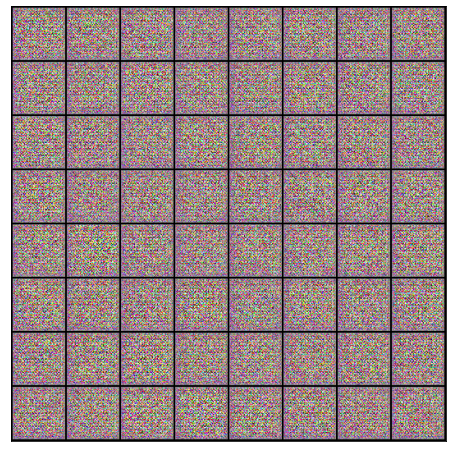

In [17]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [18]:
generator = to_device(generator, device)

In [19]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated-art'
os.makedirs(sample_dir, exist_ok=True)

In [23]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [24]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


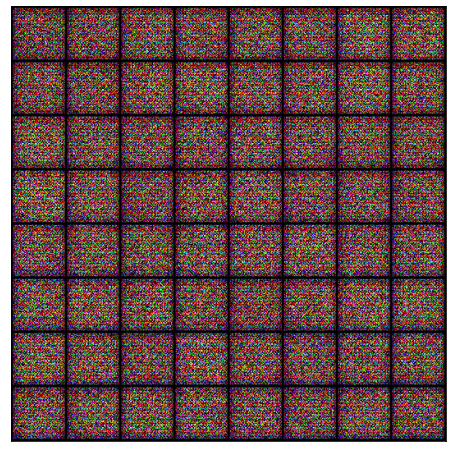

In [25]:
save_samples(0, fixed_latent)

In [26]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [27]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [28]:
lr = 0.001
epochs = 100

In [29]:
history = fit(epochs,lr)

  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 1.8914, loss_d: 0.8106, real_score: 0.7503, fake_score: 0.3025
Saving generated-images-0001.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 2.0596, loss_d: 0.8579, real_score: 0.5479, fake_score: 0.1861
Saving generated-images-0002.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 2.2217, loss_d: 1.1844, real_score: 0.5050, fake_score: 0.3229
Saving generated-images-0003.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 3.5047, loss_d: 0.8749, real_score: 0.7652, fake_score: 0.4190
Saving generated-images-0004.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 3.1352, loss_d: 1.5157, real_score: 0.8312, fake_score: 0.6939
Saving generated-images-0005.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 1.2243, loss_d: 1.5359, real_score: 0.3907, fake_score: 0.2931
Saving generated-images-0006.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 1.9805, loss_d: 0.7792, real_score: 0.5956, fake_score: 0.1619
Saving generated-images-0007.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 1.7880, loss_d: 1.0074, real_score: 0.6948, fake_score: 0.4159
Saving generated-images-0008.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 3.0996, loss_d: 1.0007, real_score: 0.7135, fake_score: 0.4551
Saving generated-images-0009.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 6.9090, loss_d: 2.1542, real_score: 0.9313, fake_score: 0.7773
Saving generated-images-0010.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 4.3253, loss_d: 0.8786, real_score: 0.8579, fake_score: 0.4771
Saving generated-images-0011.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 4.7205, loss_d: 1.3152, real_score: 0.7874, fake_score: 0.5978
Saving generated-images-0012.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 2.6348, loss_d: 0.7978, real_score: 0.6617, fake_score: 0.2591
Saving generated-images-0013.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 2.4026, loss_d: 0.5435, real_score: 0.7666, fake_score: 0.2166
Saving generated-images-0014.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.4450, loss_d: 1.0691, real_score: 0.4671, fake_score: 0.1639
Saving generated-images-0015.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 2.4706, loss_d: 1.0887, real_score: 0.6356, fake_score: 0.3458
Saving generated-images-0016.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 2.0890, loss_d: 0.2637, real_score: 0.8577, fake_score: 0.0858
Saving generated-images-0017.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 6.9811, loss_d: 1.5729, real_score: 0.9435, fake_score: 0.7017
Saving generated-images-0018.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 2.8658, loss_d: 0.7655, real_score: 0.5604, fake_score: 0.0466
Saving generated-images-0019.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 3.7005, loss_d: 0.6454, real_score: 0.6128, fake_score: 0.0612
Saving generated-images-0020.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 3.9481, loss_d: 0.4156, real_score: 0.8448, fake_score: 0.1916
Saving generated-images-0021.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 3.4548, loss_d: 0.4010, real_score: 0.7698, fake_score: 0.0945
Saving generated-images-0022.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.4884, loss_d: 1.0009, real_score: 0.8766, fake_score: 0.5182
Saving generated-images-0023.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 5.1027, loss_d: 0.9499, real_score: 0.8915, fake_score: 0.5026
Saving generated-images-0024.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 4.5546, loss_d: 1.0541, real_score: 0.8589, fake_score: 0.4908
Saving generated-images-0025.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 4.7715, loss_d: 0.6769, real_score: 0.8781, fake_score: 0.3753
Saving generated-images-0026.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 5.1567, loss_d: 1.4925, real_score: 0.6899, fake_score: 0.6098
Saving generated-images-0027.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 2.7977, loss_d: 0.9009, real_score: 0.7578, fake_score: 0.3985
Saving generated-images-0028.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 2.5006, loss_d: 1.0397, real_score: 0.6755, fake_score: 0.3892
Saving generated-images-0029.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 2.3710, loss_d: 0.6474, real_score: 0.7610, fake_score: 0.2515
Saving generated-images-0030.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 4.4858, loss_d: 0.9933, real_score: 0.8867, fake_score: 0.5335
Saving generated-images-0031.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.8238, loss_d: 1.6105, real_score: 0.8866, fake_score: 0.7074
Saving generated-images-0032.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 2.8301, loss_d: 0.5055, real_score: 0.7664, fake_score: 0.1716
Saving generated-images-0033.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 2.9517, loss_d: 0.5698, real_score: 0.7616, fake_score: 0.1957
Saving generated-images-0034.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 3.9964, loss_d: 1.5535, real_score: 0.8813, fake_score: 0.6608
Saving generated-images-0035.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.4272, loss_d: 0.6255, real_score: 0.8914, fake_score: 0.3482
Saving generated-images-0036.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.8489, loss_d: 0.7315, real_score: 0.8342, fake_score: 0.3621
Saving generated-images-0037.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 3.7437, loss_d: 0.8859, real_score: 0.7850, fake_score: 0.4065
Saving generated-images-0038.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 3.7322, loss_d: 0.7594, real_score: 0.9269, fake_score: 0.4319
Saving generated-images-0039.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 1.1081, loss_d: 0.8852, real_score: 0.5425, fake_score: 0.0957
Saving generated-images-0040.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 0.4935, loss_d: 1.2190, real_score: 0.3871, fake_score: 0.0343
Saving generated-images-0041.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 2.6340, loss_d: 0.5561, real_score: 0.6413, fake_score: 0.0290
Saving generated-images-0042.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 4.0097, loss_d: 0.4744, real_score: 0.8898, fake_score: 0.2699
Saving generated-images-0043.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 3.5928, loss_d: 0.5155, real_score: 0.9184, fake_score: 0.3090
Saving generated-images-0044.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 1.2319, loss_d: 0.9664, real_score: 0.4925, fake_score: 0.1139
Saving generated-images-0045.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 1.8316, loss_d: 0.4553, real_score: 0.8295, fake_score: 0.1983
Saving generated-images-0046.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 0.8322, loss_d: 1.1210, real_score: 0.4939, fake_score: 0.1803
Saving generated-images-0047.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 0.5711, loss_d: 1.2088, real_score: 0.4206, fake_score: 0.0438
Saving generated-images-0048.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 4.6404, loss_d: 1.2886, real_score: 0.8823, fake_score: 0.5288
Saving generated-images-0049.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 0.5037, loss_d: 1.1606, real_score: 0.4486, fake_score: 0.0446
Saving generated-images-0050.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 3.7166, loss_d: 0.4687, real_score: 0.8329, fake_score: 0.2107
Saving generated-images-0051.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.0444, loss_d: 0.3913, real_score: 0.9061, fake_score: 0.2188
Saving generated-images-0052.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 3.2713, loss_d: 0.6257, real_score: 0.8225, fake_score: 0.2625
Saving generated-images-0053.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 5.5935, loss_d: 0.2904, real_score: 0.9662, fake_score: 0.2028
Saving generated-images-0054.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 5.7996, loss_d: 0.4554, real_score: 0.9577, fake_score: 0.2761
Saving generated-images-0055.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 3.9322, loss_d: 0.2895, real_score: 0.8521, fake_score: 0.0982
Saving generated-images-0056.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 2.5049, loss_d: 0.7663, real_score: 0.5761, fake_score: 0.0416
Saving generated-images-0057.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 2.6787, loss_d: 0.3825, real_score: 0.8280, fake_score: 0.1321
Saving generated-images-0058.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 5.4857, loss_d: 0.4703, real_score: 0.8920, fake_score: 0.2304
Saving generated-images-0059.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 1.6089, loss_d: 0.5881, real_score: 0.6441, fake_score: 0.0536
Saving generated-images-0060.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 4.2945, loss_d: 0.4085, real_score: 0.9728, fake_score: 0.2676
Saving generated-images-0061.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 5.8282, loss_d: 0.4466, real_score: 0.9808, fake_score: 0.2873
Saving generated-images-0062.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 2.9961, loss_d: 0.3980, real_score: 0.7463, fake_score: 0.0326
Saving generated-images-0063.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 1.8393, loss_d: 0.5413, real_score: 0.6476, fake_score: 0.0363
Saving generated-images-0064.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 2.1612, loss_d: 0.4959, real_score: 0.7025, fake_score: 0.0677
Saving generated-images-0065.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 6.3201, loss_d: 1.0220, real_score: 0.8976, fake_score: 0.4634
Saving generated-images-0066.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 1.7049, loss_d: 0.6609, real_score: 0.6463, fake_score: 0.0756
Saving generated-images-0067.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 3.4370, loss_d: 0.3530, real_score: 0.8818, fake_score: 0.1575
Saving generated-images-0068.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.1746, loss_d: 0.5092, real_score: 0.6743, fake_score: 0.0339
Saving generated-images-0069.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 3.3138, loss_d: 0.2012, real_score: 0.8635, fake_score: 0.0336
Saving generated-images-0070.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 4.1233, loss_d: 0.5463, real_score: 0.9801, fake_score: 0.3252
Saving generated-images-0071.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.0730, loss_d: 0.2624, real_score: 0.9312, fake_score: 0.1458
Saving generated-images-0072.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 3.2524, loss_d: 0.1486, real_score: 0.9168, fake_score: 0.0408
Saving generated-images-0073.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 6.9498, loss_d: 1.0575, real_score: 0.9991, fake_score: 0.5222
Saving generated-images-0074.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 1.8504, loss_d: 0.6174, real_score: 0.6992, fake_score: 0.1134
Saving generated-images-0075.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 3.5304, loss_d: 0.0954, real_score: 0.9700, fake_score: 0.0577
Saving generated-images-0076.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 6.4242, loss_d: 0.1207, real_score: 0.9001, fake_score: 0.0036
Saving generated-images-0077.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 5.3732, loss_d: 0.2874, real_score: 0.9220, fake_score: 0.1265
Saving generated-images-0078.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 1.6745, loss_d: 0.5797, real_score: 0.7061, fake_score: 0.1136
Saving generated-images-0079.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 2.9220, loss_d: 0.2830, real_score: 0.8530, fake_score: 0.0884
Saving generated-images-0080.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 6.1197, loss_d: 0.1667, real_score: 0.9648, fake_score: 0.0970
Saving generated-images-0081.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 3.4218, loss_d: 0.3198, real_score: 0.7774, fake_score: 0.0185
Saving generated-images-0082.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 0.2183, loss_d: 1.1092, real_score: 0.5256, fake_score: 0.0061
Saving generated-images-0083.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 1.6588, loss_d: 0.4527, real_score: 0.7222, fake_score: 0.0250
Saving generated-images-0084.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.7858, loss_d: 0.1505, real_score: 0.9174, fake_score: 0.0484
Saving generated-images-0085.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.3395, loss_d: 0.1507, real_score: 0.9729, fake_score: 0.1007
Saving generated-images-0086.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 5.6314, loss_d: 0.0976, real_score: 0.9279, fake_score: 0.0149
Saving generated-images-0087.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 4.8706, loss_d: 0.1638, real_score: 0.9208, fake_score: 0.0536
Saving generated-images-0088.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 3.1610, loss_d: 0.5316, real_score: 0.7046, fake_score: 0.0483
Saving generated-images-0089.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 2.5142, loss_d: 0.3648, real_score: 0.8193, fake_score: 0.0772
Saving generated-images-0090.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 4.6067, loss_d: 0.1244, real_score: 0.9159, fake_score: 0.0243
Saving generated-images-0091.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 5.6592, loss_d: 0.1269, real_score: 0.9756, fake_score: 0.0866
Saving generated-images-0092.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 2.7215, loss_d: 0.3326, real_score: 0.8029, fake_score: 0.0469
Saving generated-images-0093.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 5.6853, loss_d: 0.1942, real_score: 0.9502, fake_score: 0.1079
Saving generated-images-0094.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 5.8765, loss_d: 0.1525, real_score: 0.9542, fake_score: 0.0748
Saving generated-images-0095.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 3.9124, loss_d: 0.3773, real_score: 0.8159, fake_score: 0.0771
Saving generated-images-0096.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.3139, loss_d: 0.3030, real_score: 0.7913, fake_score: 0.0094
Saving generated-images-0097.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 6.6273, loss_d: 0.4472, real_score: 0.8737, fake_score: 0.2020
Saving generated-images-0098.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 1.1527, loss_d: 0.5412, real_score: 0.6594, fake_score: 0.0225
Saving generated-images-0099.png


  0%|          | 0/97 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 3.7943, loss_d: 0.0845, real_score: 0.9659, fake_score: 0.0430
Saving generated-images-0100.png


In [30]:
from IPython.display import Image 

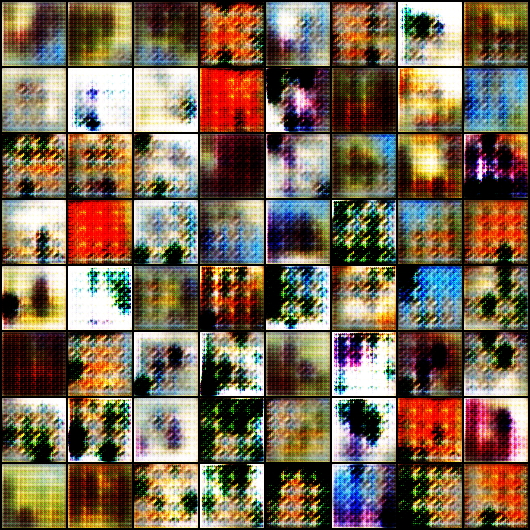

In [44]:
Image('Z:/ArtGenerator/generated-art/generated-images-0013.png')

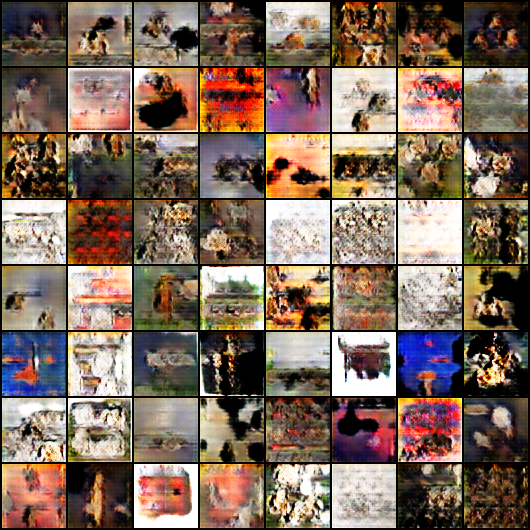

In [45]:
Image('Z:/ArtGenerator/generated-art/generated-images-0040.png')

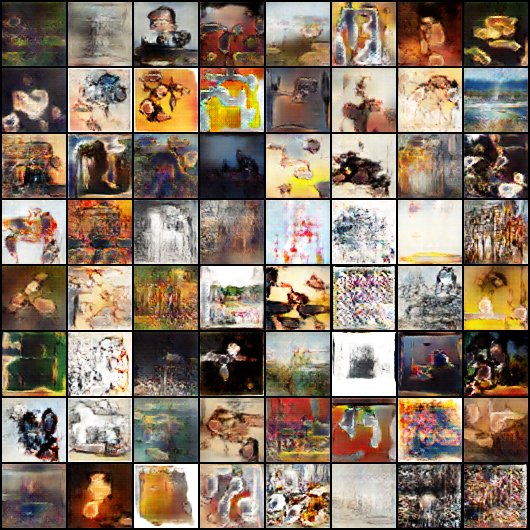

In [46]:
Image('Z:/ArtGenerator/generated-art/generated-images-0072.png')

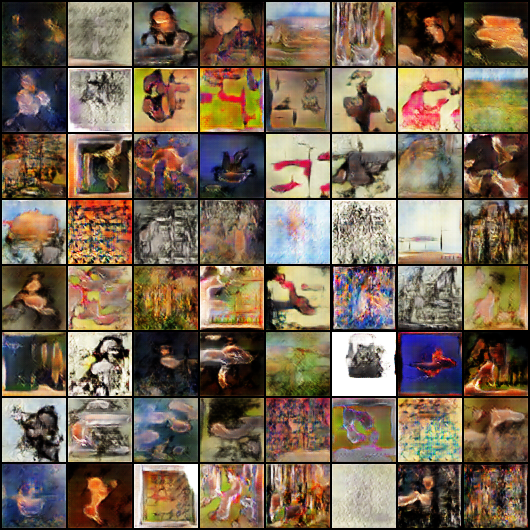

In [47]:
Image('Z:/ArtGenerator/generated-art/generated-images-0100.png')

In [38]:
losses_g, losses_d, real_scores, fake_scores = history

In [39]:
loss_g=losses_g[-1]
loss_d=losses_d[-1]
real_score=real_scores[-1]
fake_score=fake_scores[-1]

In [40]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G - ART.ckpt')
torch.save(discriminator.state_dict(), 'D - ART.ckpt')

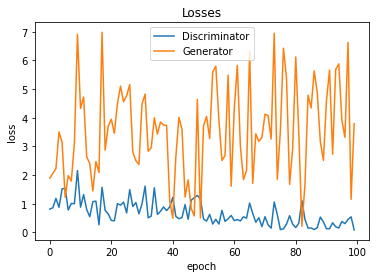

In [41]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

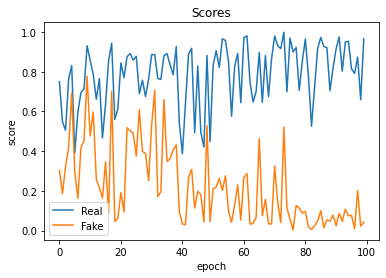

In [42]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [43]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

ModuleNotFoundError: No module named 'cv2'